# Speech Recognition

##1. Overview of Speech Recognition
###1.1 What is Speech Recognition?
 Speech recognition is a technology that enables computers to understand and convert spoken language into text. It utilizes advanced machine learning and deep learning techniques to analyze audio signals, extract meaningful features, and match them to corresponding words or phonemes.

This technology is widely used in various applications, such as voice assistants (e.g., Siri, Google Assistant, Bixby), automatic transcription services, and voice-controlled smart devices. Modern speech recognition systems leverage neural networks and large-scale datasets to achieve high accuracy, even in noisy environments or with different accents.

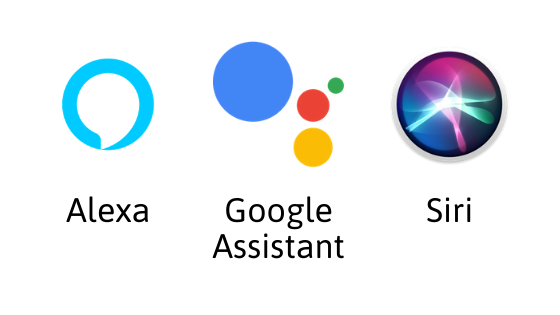



---


###1.2 Basic Process of Speech Recognition
Speech recognition is a technology that converts audio signals into text through multiple stages. The key steps are as follows:
1. Audio Input (Raw Waveform)
- The system records real-time speech via a microphone or loads a pre-recorded audio file.
- At this stage, the raw audio signal is captured and input into the computer.
2. Feature Extraction
- The input speech signal is transformed into a format that a computer can process.
- A commonly used method is MFCC (Mel-Frequency Cepstral Coefficients), which mimics how the human ear perceives sound and extracts essential acoustic features.
- This process analyzes the frequency composition and temporal characteristics of speech, converting it into data suitable for model training.
3. Acoustic Model Processing
- This stage involves learning and interpreting the speech signal based on the extracted features.
- In this practice, we use a CNN + RNN + DNN structure to effectively learn speech patterns.
- Particularly, the CTC (Connectionist Temporal Classification) algorithm is applied to align speech and text even when their lengths differ, enabling accurate transcription.
4. Decoding
- The model's output consists of probability distributions, which must be converted into actual words or phonemes.
- Here, we use CTC Greedy Decoding, selecting the most probable sequence to convert speech into text.
- Additional post-processing can be applied at this stage to enhance transcription accuracy.

Through these steps—audio input, feature extraction, acoustic model processing, and decoding—a speech recognition system ultimately generates text that users can understand. Each stage plays a crucial role in ensuring accurate transcription and reliable performance.



---


###1.3 Why Use CTC (Connectionist Temporal Classification)?
In speech recognition, the length of the input (audio signal) and the output (text) often do not match. Unlike image classification, where input and output are usually fixed, speech data is time-dependent and variable in length.

For example, consider the word "hello" spoken by different people:
- One speaker may say it in 0.5 seconds, while another may take 1.2 seconds.
- The waveform lengths are different, but both should map to the same transcription: `"hello"`

Traditional RNN-based models require pre-aligned input-output pairs, making them unsuitable for speech recognition, where alignment is unknown. This is where CTC (Connectionist Temporal Classification) becomes useful.

####How Does CTC Work?
CTC allows the model to learn variable-length sequences without needing explicit alignment between input (audio frames) and output (text). It does this by introducing a Blank (`ε`) token, which helps in handling different input lengths.


**Example**: Aligning `"hello!"` with Audio Frames

Imagine we have an audio clip that contains the word "hello!", and the model processes it into 11 time steps:

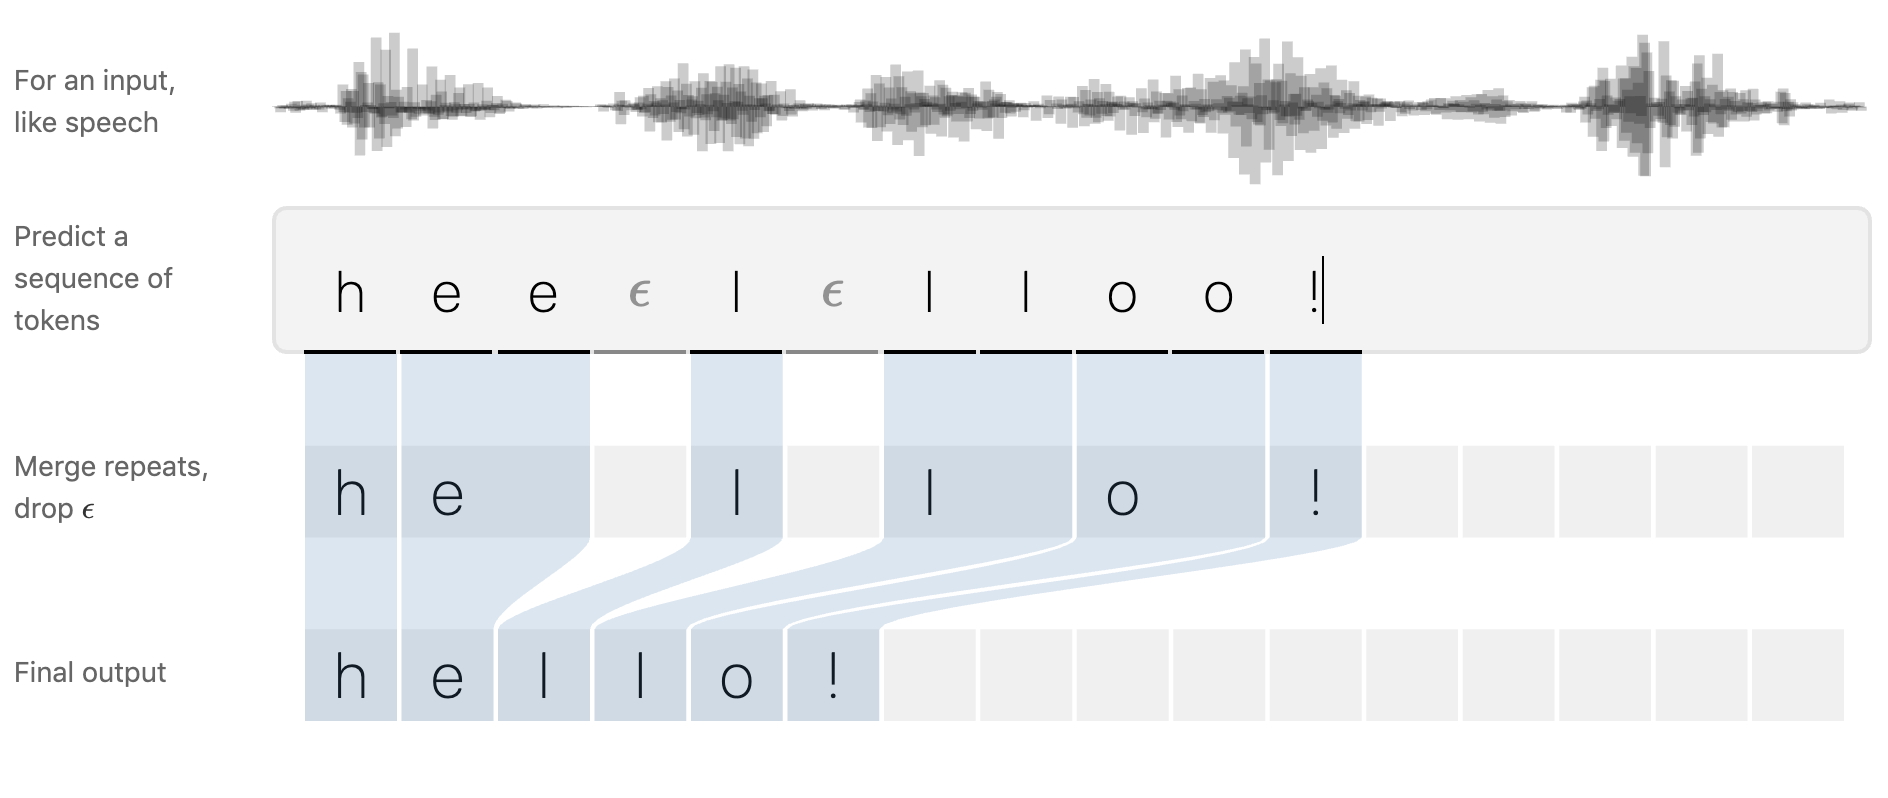

- The Blank (`ε`) token represents gaps in speech, allowing flexibility in alignment.
- Multiple occurrences of the same letter (e.g., `"ee"`) are collapsed into one (`"e"`).

CTC processes these sequences by removing duplicate characters and blank tokens, producing the final output: `hello!`



---

##2. Practice Overview
###2.1 Practice Objectives
Using SpeechBrain, we train and evaluate a CTC-based speech recognition model. This process involves training the model on a small dataset and experiencing how speech is converted into phonemes.



###2.2 Practice Process
1. Install SpeechBrain and essential libraries, and set up the environment.
2. Load and preprocess the tiny dataset.
3. Implement a CNN + RNN + DNN-based CTC speech recognition model.
4. Train and evaluate the CTC model.
5. Use the trained model to convert speech files into text(phoneme).

Students will follow this process step by step, gaining hands-on experience in processing speech data, training the model, and converting real speech into text.

####Guidelines for Practice
This practice file is not intended to explain SpeechBrain, a PyTorch-based speech recognition library, but rather to provide an experience of the overall speech recognition process. Therefore, it does not cover the principles of model training or data processing in SpeechBrain in detail.

If you are new to SpeechBrain, it is completely normal not to understand every line of code. The key objective is to experience the workflow of speech recognition, so don’t worry if some parts of the code seem difficult to grasp.

If you wish to gain a deeper understanding of SpeechBrain and its speech recognition process, please refer to the "https://speechbrain.github.io/"


---

# Practice

##3. Library Installation and Environment Setup

Install the SpeechBrain library and set up the environment for the practice.

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH
!python -m pip install hyperpyyaml

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

In [ ]:
import pathlib

from hyperpyyaml import load_hyperpyyaml

import torch
import speechbrain as sb

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


Library installation and environment setup may take some time (approximately 3 minutes).
In the next step, we will examine the training samples and prepare the dataset.



---

##4. Dataset

In this practice, we will train a speech recognition model using a very small dataset provided by SpeechBrain.
The training samples are stored in JSON format and contain the following information:
* `ASR_train.json` (Training data)
* `ASR_dev.json` (Validation data)


```yaml
"spk1_snt1": {
        "wav": "{data_root}/spk1_snt1.wav",
        "duration": "2.87",
        "phn": "dh ax cl ch ay l vcl d ao l m ow s cl t hh er cl t sil dh ax s m ao l vcl d ao vcl",
        "char": "t h e c h i l d a l m o s t h u r t t h e s m a l l d o g ",
        "label": "THE CHILD ALMOST HURT THE SMALL DOG",
}
```
* `spk1_snt1`: Unique sample ID
* `wav`: Audio file path
* `duration`: Audio length
* `phn`: phonemes
* `char`: Ground truth text
* `label`: Ground truth label



The code below loads and plays the audio mentioned above.

In [ ]:
import IPython.display as ipd
ipd.Audio('/content/speechbrain/tests/samples/ASR/spk1_snt1.wav')

###SpeechBrain Dataset Preparation Code
The code below processes audio and text data using JSON files that contain information about the audio samples, making them compatible with SpeechBrain.

Simply put, this code converts speech files and their corresponding text (phoneme) data into SpeechBrain's dataset format.

In [ ]:
def data_prep(data_folder, hparams):
    """Creates the datasets and their data processing pipelines."""
    # 1. The JSON file containing information about the audio samples is loaded and converted into SpeechBrain's dataset format.
    train_data = sb.dataio.dataset.DynamicItemDataset.from_json(
        json_path=data_folder / "../annotation/ASR_train.json",
        replacements={"data_root": data_folder},
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_json(
        json_path=data_folder / "../annotation/ASR_dev.json",
        replacements={"data_root": data_folder},
    )
    datasets = [train_data, valid_data]

    # 2. Text encoder for CTC (Phoneme ↔ Number conversion)
    label_encoder = sb.dataio.encoder.CTCTextEncoder()
    label_encoder.expect_len(hparams["num_labels"]) # In this practice, we use 43 phonemes + 1 blank.

    # 3. Audio Data Processing (Loading Waveform)
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 4. Text Data Processing (Converting Phonemes to Numbers)
    @sb.utils.data_pipeline.takes("phn")
    @sb.utils.data_pipeline.provides("phn_list", "phn_encoded")
    def text_pipeline(phn):
        phn_list = phn.strip().split()
        yield phn_list
        phn_encoded = label_encoder.encode_sequence_torch(phn_list)
        yield phn_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 5. Fit encoder
    # NOTE: In this minimal example, also update from valid data
    label_encoder.insert_blank(index=hparams["blank_index"])
    label_encoder.update_from_didataset(train_data, output_key="phn_list")
    label_encoder.update_from_didataset(valid_data, output_key="phn_list")

    # 6. Set output
    sb.dataio.dataset.set_output_keys(datasets, ["id", "sig", "phn_encoded"])

    return train_data, valid_data, label_encoder

1. The first step in the `data_prep` function is loading the dataset (JSON file).
```python
train_data = sb.dataio.dataset.DynamicItemDataset.from_json(
    json_path=data_folder / "../annotation/ASR_train.json",
    replacements={"data_root": data_folder},
)
valid_data = sb.dataio.dataset.DynamicItemDataset.from_json(
    json_path=data_folder / "../annotation/ASR_dev.json",
    replacements={"data_root": data_folder},
)
datasets = [train_data, valid_data]
```
The `ASR_train.json` (training data) and `ASR_dev.json` (validation data) are loaded in SpeechBrain format. During this process, `data_root` is used to automatically adjust the data path, and `train_data` and `valid_data` are combined into a list and stored in datasets.

2. Text encoder for CTC (Phoneme ↔ Number conversion)
```python
label_encoder = sb.dataio.encoder.CTCTextEncoder()
label_encoder.expect_len(hparams["num_labels"]) # phonemes 43 + blank 1
```
An encoder is created to convert text data into numbers for CTC training. Here, `hparams["num_labels"]` is set to 44, indicating that there are 43 phonemes and 1 blank.

3. Audio Data Processing (Loading Waveform)
```python
@sb.utils.data_pipeline.takes("wav")
@sb.utils.data_pipeline.provides("sig")
def audio_pipeline(wav):
    sig = sb.dataio.dataio.read_audio(wav)
    return sig
sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)
```
The `wav` field, which contains the audio file path, is used to load the speech sample and convert it into a waveform (`sig`). The `sig` (waveform data) is then added to the SpeechBrain dataset. Simply put, this process converts the audio file into a numerical waveform representation, making it compatible with SpeechBrain.

4. Text Data Processing (Converting Phonemes to Numbers)
```python
@sb.utils.data_pipeline.takes("phn")
@sb.utils.data_pipeline.provides("phn_list", "phn_encoded")
def text_pipeline(phn):
    phn_list = phn.strip().split()
    yield phn_list
    phn_encoded = label_encoder.encode_sequence_torch(phn_list)
    yield phn_encoded
sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)
```
The `phn` (phoneme list) is received and converted into a character list: -> "dh ax cl ch ay l vcl" -> ["dh", "ax", "cl", "ch", "ay", "l", "vcl"] At this stage, `label_encoder.encode_sequence_torch()` is used to convert phonemes into numerical values.
Simply put, this process transforms text data into numbers, preparing it for SpeechBrain's model training.

5. Fit encoder
```python
label_encoder.insert_blank(index=hparams["blank_index"])
label_encoder.update_from_didataset(train_data, output_key="phn_list")
label_encoder.update_from_didataset(valid_data, output_key="phn_list")
```
Since CTC requires a Blank Token (`ε`), a blank index is added. During this process, the phoneme data from train_data and valid_data is used to train the encoder. The reason we use the term **"train"** here is that the encoder is responsible for mapping phonemes to numbers and vice versa. However, it does not store mappings for all possible phonemes and numbers. Keeping unnecessary phoneme mappings would be a waste of resources, so the encoder is trained to match only the phonemes that actually exist in the dataset.

6. Finalizing the Dataset for SpeechBrain
```python
sb.dataio.dataset.set_output_keys(datasets, ["id", "sig", "phn_encoded"])
```
The final dataset is organized to be compatible with SpeechBrain. `id` : Unique sample ID `sig` : Audio waveform data `phn_encoded`: Phoneme data converted into numerical values

To summarize the tasks performed by the `data_prep()` function:
1. Load JSON files and convert them into a format compatible with SpeechBrain.
2. Read audio data and convert it into a waveform.
3. Convert text (phonemes) into numerical values to prepare for CTC training.
4. Add a blank token and train the encoder for CTC learning.
5. Prepare the final dataset for SpeechBrain to train on.







##5. Implementing a CTC-Based Speech Recognition Model
Now, we will implement a simple CTC-based speech recognition model using CNN + RNN + DNN by extending SpeechBrain’s `Brain` class.

### Model Definition (Implementing the CTCBrain Class)
This code extends SpeechBrain’s `Brain` class to implement a CTC (Connectionist Temporal Classification) based speech recognition model.

Simply put, it defines the process of receiving speech input, computing probabilities, and training the model based on these probabilities.

In [ ]:
class CTCBrain(sb.Brain):
    def compute_forward(self, batch, stage):
        """Given an input batch it computes the output probabilities."""
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)
        x = self.modules.model(feats)
        x = self.modules.lin(x)
        outputs = self.hparams.softmax(x)

        return outputs, lens

    def compute_objectives(self, predictions, batch, stage):
        """Given the network predictions and targets computed the CTC loss."""
        predictions, lens = predictions
        phns, phn_lens = batch.phn_encoded
        loss = self.hparams.compute_cost(predictions, phns, lens, phn_lens)

        if stage != sb.Stage.TRAIN:
            seq = sb.decoders.ctc_greedy_decode(
                predictions, lens, blank_id=self.hparams.blank_index
            )
            self.per_metrics.append(batch.id, seq, phns, target_len=phn_lens)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called when a stage (either training, validation, test) starts."""
        if stage != sb.Stage.TRAIN:
            self.per_metrics = self.hparams.per_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of a stage."""
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        if stage == sb.Stage.VALID and epoch is not None:
            print("Epoch %d complete" % epoch)
            print("Train loss: %.2f" % self.train_loss)

        if stage != sb.Stage.TRAIN:
            print(stage, "loss: %.2f" % stage_loss)
            print(stage, "PER: %.2f" % self.per_metrics.summarize("error_rate"))


1. `compute_forward()` - The Process of How the Model Handles Speech
```python
def compute_forward(self, batch, stage):
    """A function that takes input (batch) data and computes output probabilities."""
    batch = batch.to(self.device)  # Move data to GPU or CPU.
    wavs, lens = batch.sig  # Retrieve input speech data (wavs) and its length (lens).

    # Extract Speech Features (e.g., MFCC)
    feats = self.modules.compute_features(wavs)
    feats = self.modules.mean_var_norm(feats, lens)  # Feature Normalization

    # Pass through the CNN + RNN + DNN model.
    x = self.modules.model(feats)
    x = self.modules.lin(x)  # Apply the final linear transformation layer.
    outputs = self.hparams.softmax(x)  # Convert to probability values using Softmax.

    return outputs, lens  # Return the prediction results and input lengths.
```
The `compute_forward()` function takes input (`batch`) data and computes output probabilities. First, it moves the input data to GPU/CPU, then extracts and normalizes speech features (MFCC). Next, the data passes through the CNN + RNN + DNN model, where the speech signal is analyzed. Finally, the function returns the output probabilities (Softmax output). Simply put, when speech is input, the model processes it and calculates the probability of each phoneme.


2. `compute_objectives()` - Calculate CTC Loss
```python
def compute_objectives(self, predictions, batch, stage):
    """Compare predictions and actual targets to calculate CTC loss."""
    predictions, lens = predictions  # Retrieve the model's predictions and length information.
    phns, phn_lens = batch.phn_encoded  # Retrieve the actual target (phoneme-encoded values).

    # Calculate CTC Loss
    loss = self.hparams.compute_cost(predictions, phns, lens, phn_lens)

    # Calculate PER during the VALID/TEST phase (when not training).
    if stage != sb.Stage.TRAIN:
        seq = sb.decoders.ctc_greedy_decode(
            predictions, lens, blank_id=self.hparams.blank_index
        )
        self.per_metrics.append(batch.id, seq, phns, target_len=phn_lens)

    return loss
```
The `compute_objectives()` function calculates the CTC loss by comparing the predicted output from `compute_forward()` with the actual target (targets). If the model is not in the training phase (VALID/TEST), it evaluates performance using PER (Phoneme Error Rate). Simply put, this function measures how much the predictions differ from the actual phonemes (CTC Loss) and also evaluates PER during validation and testing.

3. `on_stage_start()` - Executed at the start of each phase (Train, Valid, Test).
```python
def on_stage_start(self, stage, epoch=None):
    """Executed at the beginning of the training (Train), validation (Valid), and testing (Test) phases."""
    if stage != sb.Stage.TRAIN:
        self.per_metrics = self.hparams.per_stats()  # Initialize variables for PER calculation.
```
The `on_stage_start()` function is executed at the beginning of the training, validation, or testing phase. In this code, when the model is not in the training phase (i.e., when PER evaluation is needed), it initializes the PER evaluation variables. Simply put, this function prepares the model for evaluating its speech recognition performance after training.


4. `on_stage_end()` - Executed at the end of each phase.
```python
def on_stage_end(self, stage, stage_loss, epoch=None):
    """Executed at the end of the training (Train), validation (Valid), and testing (Test) phases."""
    
    # Save the loss during the training (Train) phase.
    if stage == sb.Stage.TRAIN:
        self.train_loss = stage_loss

    # Print the loss during the validation (VALID) phase.
    if stage == sb.Stage.VALID and epoch is not None:
        print("Epoch %d complete" % epoch)
        print("Train loss: %.2f" % self.train_loss)

    # Print PER during the validation (VALID) or testing (TEST) phase.
    if stage != sb.Stage.TRAIN:
        print(stage, "loss: %.2f" % stage_loss)
        print(stage, "PER: %.2f" % self.per_metrics.summarize("error_rate"))
```
The `on_stage_end()` function is executed at the end of the training, validation, or testing phase.
In this code:
When training is completed, it stores the Train Loss.
During the validation phase, it prints the Train Loss.
In the validation (VALID) or testing (TEST) phases, it also prints the PER (Phoneme Error Rate).
Simply put, this function checks the training progress by printing the loss and performance metrics at the end of each phase.



To summarize the tasks of the `CTCBrain` class:
1. `compute_forward()` - Processes speech input and computes probability values (Softmax).
2. `compute_objectives()` - Calculates CTC Loss and performs evaluation (PER).
3. `on_stage_start()` - Initializes PER at the start of the validation/testing phase.
4. `on_stage_end()` - Prints Loss and PER after training is completed.

###Where is CNN+RNN+DNN?
We have defined the speech recognition model class and written the training and evaluation code above. However, despite initially stating that we would build a CNN + RNN + DNN-based speech recognition model, those specific terms do not appear in the code.

The reason is that SpeechBrain defines the model architecture through a YAML file. Below is the **YAML** file that contains the model definition used in this practice.

```yaml
# Training params
N_epochs: 15
lr: 0.002
dataloader_options:
    batch_size: 1

# Special tokens and labels
blank_index: 0
num_labels: 44

# Model parameters
activation: !name:torch.nn.LeakyReLU []
dropout: 0.15
cnn_blocks: 1
cnn_channels: (16,)
cnn_kernelsize: (3, 3)
rnn_layers: 1
rnn_neurons: 128
rnn_bidirectional: True
dnn_blocks: 1
dnn_neurons: 128

compute_features: !new:speechbrain.lobes.features.MFCC

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

model: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, 660]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    time_pooling: True
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>

lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <num_labels>
    bias: False

softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>

modules:
    compute_features: !ref <compute_features>
    model: !ref <model>
    lin: !ref <lin>
    mean_var_norm: !ref <mean_var_norm>

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

per_stats: !name:speechbrain.utils.metric_stats.ErrorRateStats

```



If you look at the contents of the YAML file, you will see that it contains information related to the model and training parameters. It is completely normal not to understand everything in the file at first.

For now, just remember that the model definition and training parameters are configured through the YAML file, and you don’t need to worry about every detail.

In the middle of the YAML file, you will find the model definition specifying `CRDNN`.
```yaml
model: !new:speechbrain.lobes.models.CRDNN.CRDNN
```
This `CRDNN` refers to a model structure that combines CNN, RNN, and DNN.In the YAML file, `CRDNN` is used as a reference to a predefined class in SpeechBrain, allowing the model to be initialized automatically without needing to manually define its architecture.

For a more detailed understanding, please refer to SpeechBrain's official documentation.("https://speechbrain.github.io/")

##6. Training and Testing the Speech Recognition Model
Now that everything is set up, it's time to train and test the speech recognition model. This involves loading the data, training the model, and converting speech into text (phonemes).

###Training Code Explanation
Before running the code for training and evaluation, let's first go over the key parts of the code to better understand the process.

1. Data Preparation
```python
    train_data, valid_data, label_encoder = data_prep(data_folder, hparams)
```
First, we execute the previously defined `data_prep` function to convert the training data (`train_data`) and validation data (`valid_data`) into the format used by SpeechBrain. During this process, we also prepare the label encoder, which converts phonemes to numbers and vice versa. Simply put, this step transforms the JSON dataset into SpeechBrain's format and prepares it for training.

2. CTC Model Initialization
```python
 # Trainer initialization
    ctc_brain = CTCBrain(
        hparams["modules"],  # Model Architecture
        hparams["opt_class"],  # Optimizer Configuration (e.g., Adam)
        hparams,  # Overall Configuration
        run_opts={"device": device},  # Execution Device (GPU/CPU)
    )
```
This code prepares the CTC speech recognition model for use in SpeechBrain.

3. Start Model Training
```python
ctc_brain.fit(
        range(hparams["N_epochs"]),  # Number of Training Epochs
        train_data,  # Training Dataset
        valid_data,  # Validation Dataset
        train_loader_kwargs=hparams["dataloader_options"],  # Training Data Loader Options
        valid_loader_kwargs=hparams["dataloader_options"],  # Validation Data Loader Options
    )
```
The `fit` function is used to train the CTC model. Here, the model is trained for a total of 15 epochs using the train_data and valid_data datasets. Simply put, this function trains the model and evaluates its performance using validation data.





###Training
Now, we will run the code to train the model.

The model will be trained for a total of 15 epochs, as defined in the YAML file above.
(This means the training dataset will be used 15 times for learning.)

In [ ]:
%cd /content/speechbrain/tests/integration/ASR_CTC
from pathlib import Path

experiment_dir = Path.cwd()
hparams_file = experiment_dir / "hyperparams.yaml"
data_folder = "../../samples/ASR/"
data_folder = (experiment_dir / data_folder).resolve()

# Load model hyper parameters:
with open(hparams_file, encoding="utf-8") as fin:
    hparams = load_hyperpyyaml(fin)

# Dataset creation
train_data, valid_data, label_encoder = data_prep(data_folder, hparams)

# Trainer initialization
ctc_brain = CTCBrain(
    hparams["modules"],
    hparams["opt_class"],
    hparams,
    run_opts={"device": "cpu"},
)

    # Training/validation loop
ctc_brain.fit(
    range(hparams["N_epochs"]),
    train_data,
    valid_data,
    train_loader_kwargs=hparams["dataloader_options"],
    valid_loader_kwargs=hparams["dataloader_options"],
)

INFO:speechbrain.utils.seed:Setting seed to 1234


/content/speechbrain/tests/integration/ASR_CTC


INFO:speechbrain.core:Gradscaler enabled: False. Using precision: fp32.
/usr/local/lib/python3.11/dist-packages/speechbrain/core.py:798: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=gradscaler_enabled)
INFO:speechbrain.core:CTCBrain Model Statistics:
* Total Number of Trainable Parameters: 1.5M
* Total Number of Parameters: 1.5M
* Trainable Parameters represent 100.0000% of the total size.
100%|██████████| 2/2 [00:00<00:00,  7.71it/s]


Epoch 0 complete
Train loss: 12.20
Stage.VALID loss: 4.78
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 1 complete
Train loss: 7.09
Stage.VALID loss: 4.44
Stage.VALID PER: 94.55


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 2 complete
Train loss: 4.71
Stage.VALID loss: 4.23
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 3 complete
Train loss: 3.68
Stage.VALID loss: 4.48
Stage.VALID PER: 89.09


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 4 complete
Train loss: 3.19
Stage.VALID loss: 4.85
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 5 complete
Train loss: 2.84
Stage.VALID loss: 4.43
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 6 complete
Train loss: 2.45
Stage.VALID loss: 4.29
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 7 complete
Train loss: 2.12
Stage.VALID loss: 4.37
Stage.VALID PER: 89.09


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Epoch 8 complete
Train loss: 1.82
Stage.VALID loss: 4.26
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 9 complete
Train loss: 1.51
Stage.VALID loss: 3.93
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


Epoch 10 complete
Train loss: 1.23
Stage.VALID loss: 4.23
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  7.80it/s]


Epoch 11 complete
Train loss: 0.96
Stage.VALID loss: 4.03
Stage.VALID PER: 92.73


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch 12 complete
Train loss: 0.75
Stage.VALID loss: 4.48
Stage.VALID PER: 87.27


100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch 13 complete
Train loss: 0.62
Stage.VALID loss: 4.24
Stage.VALID PER: 90.91


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

Epoch 14 complete
Train loss: 0.44
Stage.VALID loss: 4.18
Stage.VALID PER: 87.27


Looking at the training logs, we can see that while Train Loss continues to decrease, Valid Loss and PER (Phoneme Error Rate) show little to no improvement or even tend to increase. This phenomenon occurs due to overfitting.

#### What is Overfitting?
Overfitting occurs when the model becomes overly adapted to the training data.
A decreasing Train Loss indicates that the model is learning the training data more accurately.
However, if Valid Loss and PER do not improve, it means the model is not generalizing well to the validation data.
In this case, overfitting happens because the training dataset is too small.

Our goal is to train the model and experience converting speech into text (phonemes). Therefore, in this practice, we can ignore the overfitting issue.

###Speech Recognition

We have trained a speech recognition model above. As observed, the model achieved low loss on the training dataset but showed high loss on the validation dataset, indicating poor generalization ability.

Since our goal is to experience speech recognition, we will now perform speech recognition using one of the audio samples from the training data.
The spk1_snt1.wav file was played at the beginning of the practice session and was also used for training.

Now, let's transcribe the `spk1_snt1.wav` file.

The transcribe function is defined to output the model's speech recognition results. It performs speech recognition using the trained model and then decodes the output using the `ctc_greedy_decode` function.

As explained earlier in the CTC decoding process, the decoding works as follows:

* Duplicate values are collapsed into a single character.
* Blank (`ε`) tokens are removed from the output.

The key takeaway is that when you pass the trained model and the file path of the audio to the transcribe function, it returns the recognized phonemes.

In [ ]:
def transcribe(model, wav):
  sig = sb.dataio.dataio.read_audio(wav)
  sig = sig.unsqueeze(0)
  len = torch.tensor(1.0000).unsqueeze(0)

  feats = model.modules.compute_features(sig)
  feats = model.modules.mean_var_norm(feats, len)
  x = model.modules.model(feats)
  x = model.modules.lin(x)
  output = model.hparams.softmax(x)

  seq = label_encoder.decode_ndim(sb.decoders.ctc_greedy_decode(output, len, blank_id=hparams["blank_index"]))
  return seq

####Result
Now, let's perform speech recognition on the `spk1_snt1.wav` audio sample using the trained model.

In [ ]:
seq = transcribe(ctc_brain, '/content/speechbrain/tests/samples/ASR/spk1_snt1.wav')
print(seq)

[['dh', 'ax', 'cl', 'ch', 'ay', 'l', 'vcl', 'd', 'ao', 'l', 'm', 'ow', 's', 'cl', 't', 'er', 'cl', 't', 'sil', 'dh', 'ax', 's', 'm', 'ao', 'l', 'vcl', 'd', 'ao', 'vcl']]


The result shows that the `spk1_snt1.wav` file has been transcribed into a list of phonemes.

Compare this output with the ground truth labels of the `spk1_snt1.wav` file to evaluate how accurately the speech recognition performed.
```yaml
"spk1_snt1": {
        "phn": "dh ax cl ch ay l vcl d ao l m ow s cl t hh er cl t sil dh ax s m ao l vcl d ao vcl",
}
```



##7. Conclusion
You have now experienced the entire speech recognition process using the SpeechBrain library, from data processing and model training to decoding.

This practice session focused on providing hands-on experience with speech recognition, rather than explaining the detailed principles of SpeechBrain or the intricate workings of speech recognition.

For those who wish to study further, please refer to the SpeechBrain website, as mentioned earlier.

##8. Reference
https://ratsgo.github.io/speechbook/

https://speechbrain.github.io/